# Fast Style Transfer

By https://arxiv.org/pdf/1603.08155.pdf and supplemential materials https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf

## Imports and data loading

In [1]:
import numpy as np
import bcolz
import importlib
import tensorflow as tf
import PIL
from PIL import ImageOps

import keras
from keras.layers import Convolution2D, Deconvolution2D, MaxPooling2D
from keras.layers import AveragePooling2D, Input, BatchNormalization, Activation
from keras.layers import merge, Lambda, UpSampling2D, Layer, InputSpec
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras import backend as K
from keras.metrics import mse
from keras_tqdm import TQDMNotebookCallback

from vgg16_avg import VGG16_Avg

%matplotlib inline
import matplotlib.pyplot as plt
import utils2
importlib.reload(utils2)
from utils2 import save_array, load_array, plot, plot_multi, limit_mem

# Print any variable that is on its own line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

Now load the data: small images (72x72) and their ground-truth(288x288)

In [3]:
imgs = load_array('../SuperResData/trn_cropped_288.bc')[:]
# large_imgs = load_array('../SuperResData/trn_resized_288.bc')
image_size = imgs.shape[1:3]
imgs.shape

(19132, 288, 288, 3)

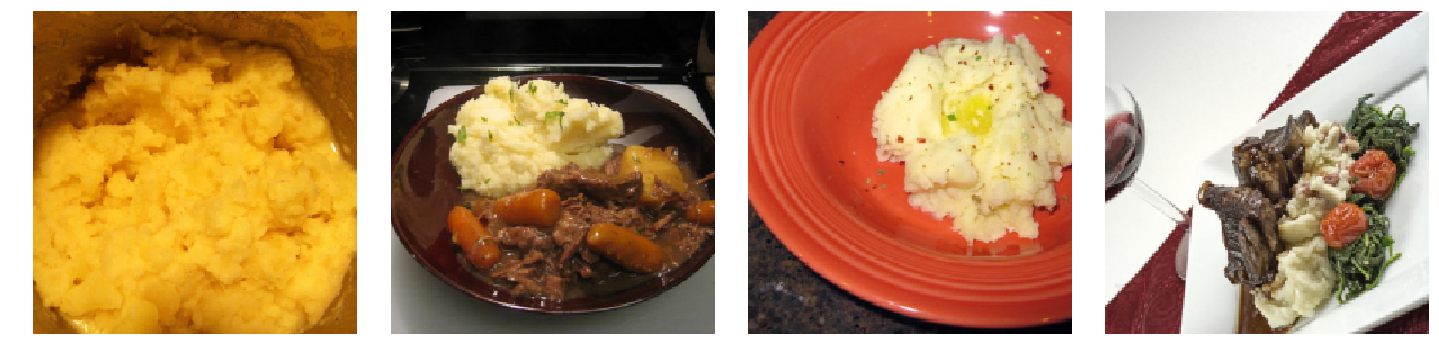

In [4]:
plot_multi(imgs[6:10].astype('uint8'), figsize=(20, 20))

## Resize Crop

Remove the black border and resize the images by cropping.

In [ ]:
def crop_border(img):
    mask = (np.mean(img, axis=2).astype('uint8')) > 0
    return img[np.ix_(mask.any(1), mask.any(0))]


def resize_crop(img, to=(288, 288)):
    image_pil = PIL.Image.fromarray(img.astype('uint8'))
    resized = ImageOps.fit(image_pil, to)
    return resized


resized_imgs = []
for index, img in enumerate(imgs):
    cropped = crop_border(img)
    if cropped.shape[0:2] == (0, 0):
        continue
    resized = resize_crop(cropped)

    resized_imgs.append(np.asarray(resized).astype('uint8'))

resized_imgs = np.asarray(resized_imgs)

save_array('../SuperResData/trn_cropped_288.bc', resized_imgs)

## Reflection Padding

In [5]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0],
                s[1] + 2 * self.padding[0],
                s[2] + 2 * self.padding[1],
                s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], mode='REFLECT')

(1, 308, 368, 3)

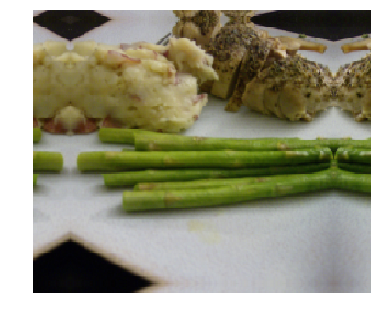

In [6]:
# Test reflection padding
test_inp = Input(image_size + (3,))
x = ReflectionPadding2D((40, 10))(test_inp)
reflected = x.eval(feed_dict={test_inp: [imgs[20]]},
                   session=K.get_session())
reflected.shape
plot_multi(reflected.astype('uint8'), figsize=(20, 20))

## Upscale net

The Upscale network that will scale the small image into a big one.

In [7]:
def conv_block(inp, filters, size, stride=1, activation=True,
               border_mode='same'):
    ''' Define a convolutional block for the upscale network.
    '''
    x = Convolution2D(filters=filters, kernel_size=size,
                      padding=border_mode, name='',
                      strides=(stride, stride))(inp)
    x = BatchNormalization()(x)
    if activation:
        return Activation(activation='relu')(x)
    else:
        return x

In [8]:
def res_block(inp, filters):
    x = conv_block(inp, filters=filters, size=(3, 3))
    x = conv_block(x, filters=filters, size=(3, 3), activation=False)
    x = merge([x, inp], mode='sum')
    return x

In [9]:
def res_block_crop(inp, filters):
    x = conv_block(inp, filters=filters, size=(3, 3), border_mode='valid')
    x = conv_block(x, filters=filters, size=(3, 3), border_mode='valid',
                   activation=False)
    # since the convolutions will cut off 2 pixels each
    inp = Lambda(lambda x: x[:, 2:-2, 2:-2])(inp)
    x = merge([x, inp], mode='sum')
    return x

In [10]:
def deconv_block(inp, filters, size, output_shape, stride=2):
    x = Deconvolution2D(nb_filter=filters,
                        nb_row=size[0], nb_col=size[1],
                        output_shape=output_shape,
                        subsample=(stride, stride), border_mode='same')(inp)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [11]:
def up_block(inp, filters, size):
    x = UpSampling2D()(inp)
    x = Convolution2D(filters, size[0], size[1], border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [12]:
inp = Input(shape=image_size + (3,))
x = ReflectionPadding2D((40, 40))(inp)
x = conv_block(x, filters=64, size=(9, 9))
x = conv_block(x, filters=64, size=(3, 3), stride=2)
x = conv_block(x, filters=64, size=(3, 3), stride=2)
for i in range(5):
    x = res_block_crop(x, 64)
x = up_block(x, 64, (3, 3))
x = up_block(x, 64, (3, 3))
# x = deconv_block(x, 64, size=(3, 3), output_shape=(None, 144, 144, 64))
# x = deconv_block(x, 64, size=(3, 3), output_shape=(None, 288, 288, 64))
x = Convolution2D(nb_filter=3, nb_row=9, nb_col=9,
                  activation='tanh', border_mode='same')(x)
enlarge_output = Lambda(lambda x: (x + 1) * 127.5)(x)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="tanh", kernel_size=(9, 9), filters=3, padding="same")`
  '` call to the Keras 2 API: ' + signature)


In [13]:
enlarge_net = Model(inp, enlarge_output)
enlarge_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 288, 288, 3)   0                                            
____________________________________________________________________________________________________
reflection_padding2d_2 (Reflecti (None, 368, 368, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 368, 368, 64)  15616                                        
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 368, 368, 64)  256                                          
___________________________________________________________________________________________

## VGG for content features

In [15]:
channel_means = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess = Lambda(lambda x: (x - channel_means)[:, :, :, ::-1])

In [16]:
vgg_input = Input(shape=imgs.shape[1:])
vgg = VGG16_Avg(include_top=False, input_tensor=Lambda(preprocess)(vgg_input))
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  '` call to the Keras 2 API: ' + signature)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding=

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [18]:
vgg_output_layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3',
                          'block4_conv3']
vgg_output_layers = [vgg.get_layer(name=name).output
                     for name in vgg_output_layer_names]
vgg_content_features = Model(
    vgg_input, vgg_output_layers)

## Style Image

(288, 288, 3)

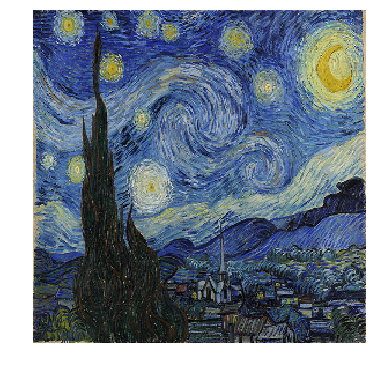

In [19]:
style_image = PIL.Image.open('starry_night.jpg')
style_image = np.asarray(style_image.resize(image_size), dtype=np.float32)
style_image.shape
plot_multi([style_image.astype('uint8')], figsize=(20, 20))

In [20]:
styles_precomputed = vgg_content_features.predict_on_batch(
    style_image[np.newaxis])
[np.squeeze(style).shape for style in styles_precomputed]
styles_precomputed = [tf.Variable(layer) for layer in styles_precomputed]

[(288, 288, 64), (144, 144, 128), (72, 72, 256), (36, 36, 512)]

## Super Res net

Upscale the small image, and minimize the loss between the upscaled and the ground truth images.


In [21]:
def rmse_batch(diff):
    dimensions = len(diff.get_shape())
    axis = list(range(1, dimensions))
    # TODO why expand dims
    rmse = K.expand_dims(K.sqrt(K.mean(K.square(diff), axis=axis)), 0)
    return rmse


def gram_matrix(layer):
    ''' Compute the gram activations of a layer.
    Args:
        layer: Tensor with shape (batch_size, width, height, channels)
    '''
    # Swap axes to (batch, channels, width, height)
    layer = tf.transpose(layer, perm=(0, 3, 1, 2))
    shape = layer.get_shape()
    # Combine the width and height dimensions
    layer = tf.reshape(layer,
                       shape=tf.stack([-1, shape[1], shape[2] * shape[3]]))
    shapes_product = tf.cast(
        shape[1] * shape[2] * shape[3], dtype=tf.float32)

    transposed_layer = tf.transpose(layer, perm=(0, 2, 1))
    gram = tf.matmul(layer, transposed_layer) / shapes_product
    return gram


def loss_func(args):
    vgg_content_layer_weights = [0.0, 0.7, 0.0, 0.0]
    content_weight = 3
    inp = args[0]
    processed = args[1]
    input_feat = vgg_content_features(inp)
    processed_feat = vgg_content_features(processed)

    loss = 0
    layers = zip(input_feat, processed_feat, vgg_content_layer_weights)
    for i, (layer1, layer2, layer_weight) in enumerate(layers):
        # style loss
        loss += rmse_batch(gram_matrix(layer2)
                           - gram_matrix(styles_precomputed[i]))
        # content loss
        loss += content_weight * rmse_batch(layer1 - layer2) * layer_weight

    return loss


# truth_input = Input(shape=large_imgs.shape[1:], name='truth_input')

loss = Lambda(loss_func, name='loss')([vgg_input, enlarge_output])
loss

<tf.Tensor 'loss/add_7:0' shape=(1, ?) dtype=float32>

In [22]:
super_res = Model([inp, vgg_input], loss)
lr = 1e-3
super_res.compile(optimizer=Adam(lr=lr), loss='mae')

In [23]:
super_res.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 288, 288, 3)   0                                            
____________________________________________________________________________________________________
reflection_padding2d_2 (Reflecti (None, 368, 368, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 368, 368, 64)  15616                                        
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 368, 368, 64)  256                                          
___________________________________________________________________________________________

In [22]:
# super_res.load_weights('reset_weights.hdf5')

In [ ]:
# params = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}
targets = np.zeros((imgs.shape[0], 1))
K.set_value(super_res.optimizer.lr, 1e-3)
super_res.fit([imgs, imgs], targets,
              batch_size=8, epochs=1)

In [ ]:
# super_res.save_weights('reset_weights.hdf5')

In [ ]:
K.set_value(super_res.optimizer.lr, 1e-4)
super_res.fit(imgs, fake_targets,
              batch_size=16, epochs=2)

In [ ]:
K.set_value(super_res.optimizer.lr, 1e-5)
super_res.fit(imgs, fake_targets,
              batch_size=16, epochs=2)

In [25]:
final_model = Model(inp, enlarge_output)
final_model.save('enlarge_model.hdf5')

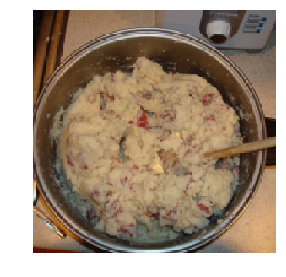

In [26]:
img_index = 11
test_img = imgs[img_index:img_index + 1]
plot_multi(test_img.astype('uint8'), figsize=(15, 15))

In [27]:
enlarged_img = final_model.predict(test_img)
enlarged_img = np.squeeze(enlarged_img.astype('uint8'))
enlarged_img.shape

(288, 288, 3)

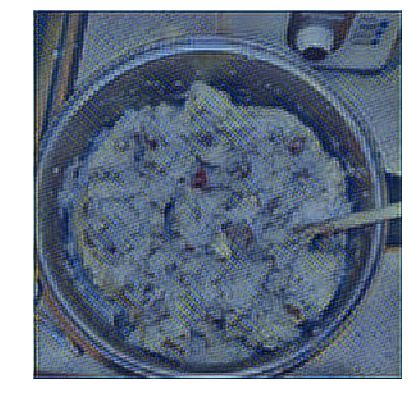

In [28]:
plot_multi([enlarged_img], figsize=(22, 22))